# The Good Will Hunting Problem

If you've seen the film [Good Will Hunting][gwh_wiki], you may recall a scene
near the beginning of the film where Fields medal-winning MIT professor Gerald Lambeau
(played by Stellan Skarsgård) presents a mathematics challenge to a classroom
full of students.
It turns out that the problem involves some basic graph theory... let's see if
we can attack it ourselves with NetworkX!

## The problem statement

The excellent [Numberphile YouTube channel](https://www.youtube.com/@numberphile)
did a very nice video on this topic.

```{warning}
Make sure to pause at **3:05** if you don't want to give away the answer!
```

<center>
  <iframe 
    width="560" 
    height="315"
    src="https://www.youtube.com/embed/iW_LkYiuTKE?si=zgyO8Pnn6eqid30P"
    title="YouTube video player"
    frameborder="0"
    allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share"
    referrerpolicy="strict-origin-when-cross-origin"
    allowfullscreen>
  </iframe>
</center>

[gwh_wiki]: https://en.wikipedia.org/wiki/Good_Will_Hunting

Here is the problem statement, quoting James from the video (starting at around `1:23`):

> Draw all homeomorphically irreducible trees of size n=10

As in the video, let's examine these terms more closely to make sure we can
understand the problem.

The first term to focus on is [*"tree"*][tree_wiki], a fundamental concept in
graph theory.
A tree refers to an undirected graph which is fully connected and contains no
cycles.
We are also given the "size" of the tree in the problem statement, i.e. the
number of nodes that the tree contains.

[tree_wiki]: https://en.wikipedia.org/wiki/Tree_(graph_theory)

Given these simple definitions, we can already start coming up with graphs that
might fit the bill.
For example, a [path graph](https://en.wikipedia.org/wiki/Path_graph) with 10 nodes is connected and contains no cycles,
and is therefore a tree!

In [1]:
import networkx as nx

G = nx.path_graph(10)
nx.is_tree(G)

True

Wow, that was easy... did we really find our first example that quickly?
Not so fast... there's still that whole business of "homeomorphic irreducibility".
Fortunately, at least in the context of this problem, this complicated-sounding
term refers to a relatively simple concept:

    A tree is homeomorphically irreducible if it contains no nodes with degree 2.

This simple interpretation can be found explicitly near the end of the
[Definitions section of the wiki article on trees][tree_wiki_defn].

[tree_wiki_defn]: https://en.wikipedia.org/wiki/Tree_(graph_theory)#Definitions

This added condition means that our path graph isn't a valid solution after all,
as it contains at least one node (8, in fact) with degree 2 (the key in the dictionary is the node and value is the degree of the node):

In [2]:
dict(G.degree)

{0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 1}

So, let's restate the problem in these less-specialized terms:

We're looking for all undirected graphs that:
 - Contain 10 nodes
 - Are fully connected
 - Contain no cycles
 - Contain no nodes with degree 2

There's one final consideration which isn't explicitly mentioned in the problem
statement.
How do we determine whether or not a graph is "unique"?

This is briefly touched on in the Numberphile video. Consider two graphs:

In [3]:
# The reason for explicit positioning will become clear in a moment

G = nx.Graph([(0, 1), (1, 2), (1, 3), (3, 4), (3, 5)])
nx.set_node_attributes(
    G, {0: (0, 2), 1: (1, 1), 2: (0, 0), 3: (2, 1), 4: (3, 2), 5: (3, 0)}, "pos"
)

H = nx.Graph([(6, 5), (5, 4), (5, 3), (3, 2), (3, 1)])
nx.set_node_attributes(
    H, {6: (0, 2), 5: (0, 1), 4: (0, 0), 3: (1, 1), 2: (1, 2), 1: (1, 0)}, "pos"
)
nx.set_node_attributes(H, values="tab:red", name="color")

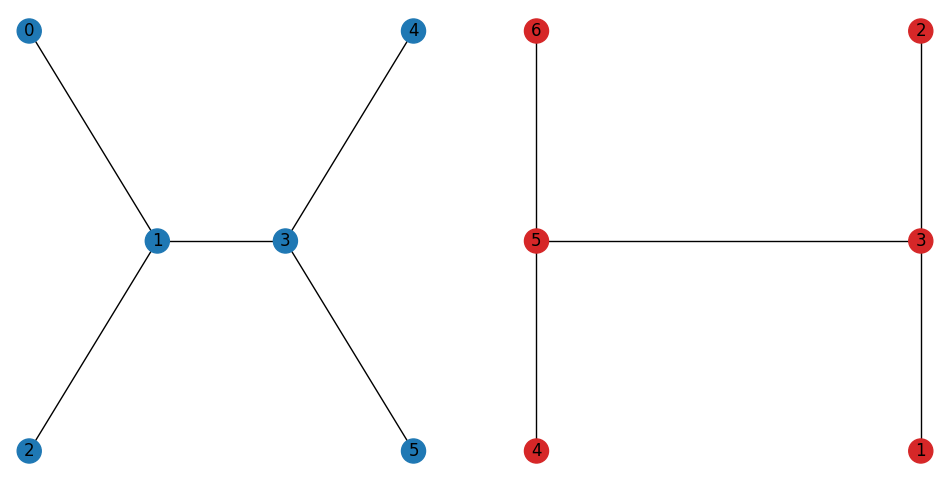

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for graph, axis in zip((G, H), ax):
    nx.display(graph, canvas=axis)
    axis.set_axis_off()

At face value, it's clear these graphs are not identical.
For starters, the numbers representing the nodes are different.
Then there's the properties of the nodes in the two graphs, e.g. the node
color or their position in the 2D visualization. 
Let's examine these differences in the context of our problem.

If we consider the node properties to be significant, then our question could have
infinite answers: all we'd need to do is find one such tree, then change the
coloring, positioning, or any other unbounded property of the nodes to get a
"new" answer.
For our purposes then, we will ignore node properties.

Similarly, there are the node labels - i.e. the values that allow us to uniquely
identify each node.
If we allow these labels to be anything (i.e. integers, letters, arbitrary symbols, etc.)
then we have the same situation as the node properties: there are infinite
ways to label the nodes.
This too we reject as uninteresting for our question.

Even if we were to limit the set of possible labels (say the integers from `[0, 9]`
for our `n=10` case), then we'd still have a scenario where graphs with the same
adjacency can be represented multiple ways by permutating the node labels.
For our purposes then, we'll also be ignoring the node labels.
In the parlance of graph theory, this means we're dealing with *unlabelled trees*.

What's left then is a comparison of the adjacencies between the two graphs.
In the context of our problem, when we say "unique" graphs what we mean are
graphs that are *nonisomorphic*.

In [5]:
nx.is_isomorphic(G, H)

True

You can learn more about isomorphism in
{doc}`other NX Guides </content/algorithms/isomorphism/index>`.

### Problem statement summary

With that final clarification, we've fully specified the problem.
We're looking for all undirected graphs that:
 - Contain 10 nodes
 - Are fully connected
 - Contain no cycles
 - Contain no nodes with degree 2
 - Are nonisomorphic with each other

## Attacking the problem

Before we go hunting for individual examples, we might ask: how many we need to find?
As noted in the video, there are 10 homeomorphically irreducible unlabeled trees
with 10 nodes.
We can confirm this by checking the corresponding sequence in the [OEIS](https://oeis.org):
[The number of series-reduced trees with n nodes][a000014].

[a000014]: https://oeis.org/A000014

### Qualitative approach

We began our investigation with a `path_graph`, which is a tree but doesn't meet
the criterion for irreducibility.
Are there any simple modifications we can think of from this starting point to
arrive at an irreducible tree?
The main issue is all of those interconnected degree-2 nodes: how could we replace
that pattern?

One common way to think about trees is as a *hierarchical* structure, with
"root" nodes and "leaf" nodes.
Perhaps this line of thinking could help here.
What if we organized our 10 nodes so that we had one "root" with the remaining
nodes as leaves?

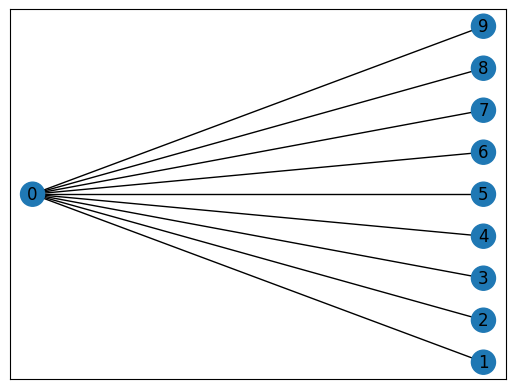

In [6]:
G = nx.Graph()
G.add_node(0)  # our "root" node

# Then, let's add each of the remaining 9 nodes as leaves connected only to
# the root
G.add_edges_from((0, n) for n in range(1, 10))

fig, ax = plt.subplots()
# Position nodes hierarchically, with "root" on one end and "leaves" on the other
pos = nx.bfs_layout(G, 0, store_pos_as="pos_bfs")

nx.display(G, node_pos="pos_bfs", canvas=ax);

This looks promising... our graph `G` is a tree:

In [7]:
nx.is_tree(G)

True

with 10 nodes:

In [8]:
len(G)

10

and, unlike the `path_graph`, doesn't contain any nodes with degree 2:

In [9]:
not any(d == 2 for _, d in G.degree())

True

It looks like we've found our first example!

#### Another perspective

We arrived at this example by thinking in terms of "roots" and "leaves", but if
we change our perspective a bit we might recognize this as an instance of a
common class of graphs...

Let's try a different layout; perhaps one that tries to evenly spread nodes
spatially rather than capture hierarchical relationships:

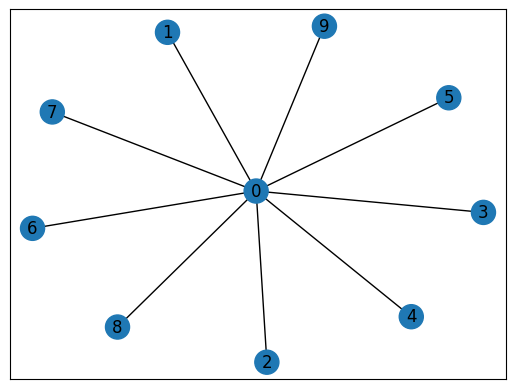

In [10]:
# A force-directed layout
pos = nx.spring_layout(G, store_pos_as="pos_spring")

fig, ax = plt.subplots()
nx.display(G, node_pos="pos_spring", canvas=ax);

That looks an awful lot like the {func}`~networkx.generators.classic.star_graph`.
And indeed it is!

In [11]:
nx.is_isomorphic(G, nx.star_graph(9))

True

It turns out in fact that `star_graph(n)` is an instance of a
homeomorphically-irreducible tree of size `n` for all `n` greater than 3.

### Finding more examples

Let's return to our initial set of ideas that led us to the `star_graph`.
Using the `star_graph` as a starting point, we can apply the same "hierarchical"
thinking to develop other examples.

For instance, what if we took some "leaves" from our original tree, and
"moved them down a layer".
We know that we don't want nodes of degree 2, so moving at least two nodes
seems like a reasonable place to start.
Let's start by re-visualizing our graph hierarchically:

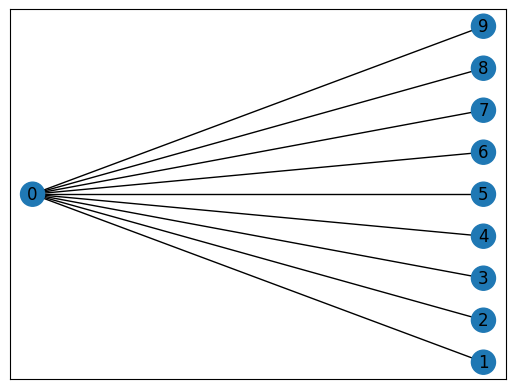

In [12]:
fig, ax = plt.subplots()

nx.display(G, node_pos="pos_bfs", canvas=ax);

Now let's try moving nodes 1 and 2 down a layer by connecting them to node 3
instead of the "root":

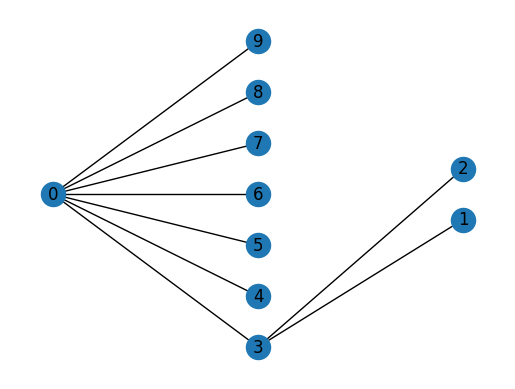

In [13]:
H = G.copy()

H.remove_edges_from([(0, 1), (0, 2)])
H.add_edges_from([(3, 1), (3, 2)])

fig, ax = plt.subplots()
nx.draw(H, pos=nx.bfs_layout(H, 0), ax=ax, with_labels=True);

This seems to meet our criteria; let's double-check!

In [14]:
nx.is_tree(H) and not any(d == 2 for _, d in H.degree())

True

Success!

That procedure worked so well the first time, let's apply it again but
attaching to node `4` instead of node `3`

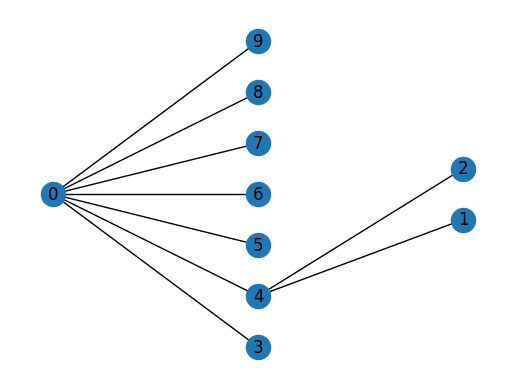

In [15]:
H1 = G.copy()

H1.remove_edges_from([(0, 1), (0, 2)])
H1.add_edges_from([(4, 1), (4, 2)])

fig, ax = plt.subplots()
nx.draw(H1, pos=nx.bfs_layout(H1, 0), ax=ax, with_labels=True);

Looks good, right? Well looks can be deceiving...

We're using hierarchical layouts and node labels to help us visualize
the changes we're making, but recall that we're looking for *nonisomorphic* trees.
While these two graphs may *look* distinct with the layouts we've chosen, they
are actually isomorphic.

In [16]:
nx.is_isomorphic(H, H1)

True

This is easier to see if we tweak how we visualize the graphs:

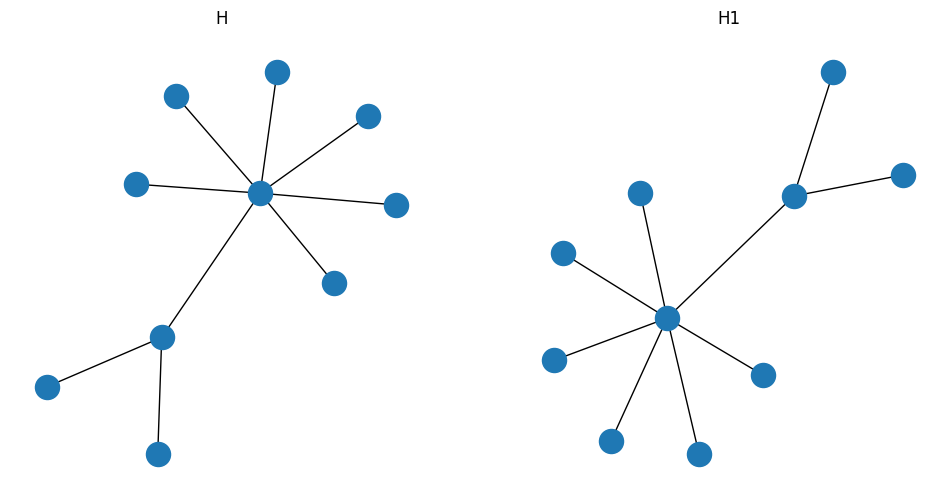

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for G, a, ttl in zip((H, H1), ax.ravel(), ("H", "H1")):
    nx.draw(G, pos=nx.spring_layout(G, seed=1000), with_labels=False, ax=a)
    a.set_title(ttl)

This is a valuable lesson in both the virtues and pitfalls of graph visualization
as a tool for working through problems!

### An algorithm

The result above represents one application of a general procedure that
should be useful in finding the remaining examples.
Start with an existing irreducible tree, then change the connectivity of
a subset of nodes to create a "deeper" tree.
Bear in mind also that we can "move" more than two nodes... what if we had moved
nodes `1`, `2`, *and* `3` in our previous example?

Formalizing this procedure into an algorithm for generating irreducible
trees is left as an exercise for the reader!

```{tip}
This is a good stopping point to see if you can't use the above procedure
(or another of your own devising!) to find the remaining 8 examples.

The next section will spoil the answer!
```

## Searching the solution space

The original problem should now be solvable with a bit of elbow grease.

But what if we didn't know how many examples we were looking for?
In other words, what if we didn't know *at the start* that there are 10
homeomorphically-irreducible trees of order 10?

For that matter, just how hard *is* this problem anyway? How "rare" are irreducible
trees?

We could get a much better sense if we had some idea of the solution space;
i.e. the number of potential solutions.
In other words, we're wondering how many nonisomorphic trees of order 10 exist?

The [OEIS](https://oeis.org) is an excellent resource when faced with questions like this,
and indeed [A000055][oeis_a000055] has exactly what we're looking for.

[oeis_a000055]: https://oeis.org/A000055

In this case, it turns out so does NetworkX!

In [18]:
nx.number_of_nonisomorphic_trees(10)

106

So there are 106 unlabelled trees with 10 nodes.
That actually seems like a quite manageable number...

### A brute-force approach

If there were a way to generate all the nonisomorphic trees with 10 nodes,
we could simply check whether or not they are homeomorphically-irreducible.
All graphs that pass this check will then give us our answer.
One nice thing about this approach is that it allows us to "prove" (by exhaustion)
that we're finding *all* examples of homeomorphically-irreducible trees for a given
order, even if we don't know how many there are *a priori*.

The downside however is also quite obvious - it requires checking
*every possible tree*.
This may be fine for small `n`, but it quickly becomes
[untenable as `n` increases](https://oeis.org/A000055/graph).

Fortunately, we were only tasked with finding the result for `n=10`!

In [19]:
nhi_trees = [
    G for G in nx.nonisomorphic_trees(10) if not any(d == 2 for _, d in G.degree())
]

That's it!

Let's do some sanity checks to make sure our result passes muster.
First, we can check that we got the expected number of trees:

In [20]:
len(nhi_trees)

10

So far so good.

We really relied on {func}`~networkx.generators.nonisomorphic_trees.nonisomorphic_trees`
to do the majority of the heavy-lifting for us.
Let's double check that the trees we recorded are indeed nonisomorphic to each
other:

In [21]:
checked = []
for G in nhi_trees:
    assert not any(nx.is_isomorphic(G, H) for H in checked)
    checked.append(G)

No `AssertionError` s ✅

### The big reveal

Finally, the fruits of our mental labor!

We can view the results using a hierarchical layout to visualize the trees in a
way that matches the line of thinking we developed in the previous section.
We'll also include the number of nodes per layer in the graph.
Can you spot any patterns?

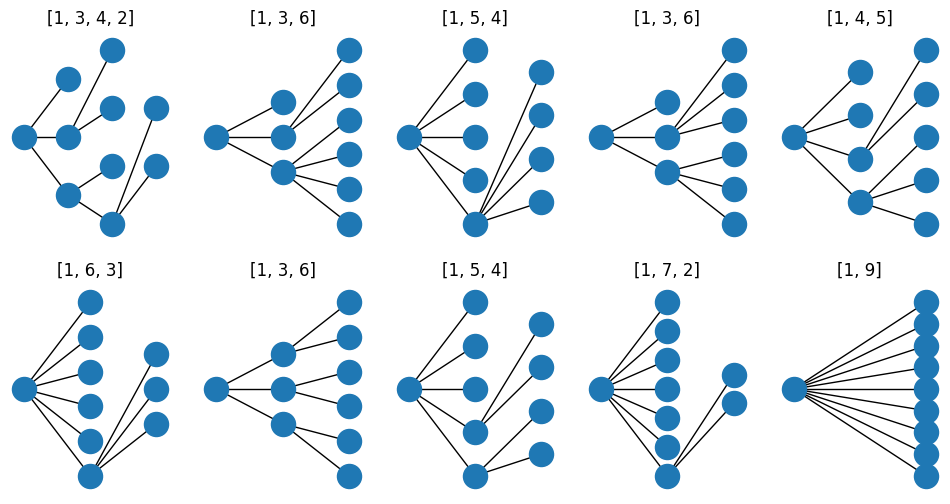

In [22]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))

for G, a in zip(nhi_trees, ax.ravel()):
    nodes_per_layer = [len(lyr) for lyr in nx.bfs_layers(G, 0)]
    nx.draw(G, pos=nx.bfs_layout(G, 0), ax=a)
    a.set_title(f"{nodes_per_layer}")

So there they are, in all their glory: all 10 homeomorphically-irreducible
unlabeled trees with 10 nodes!

We'd be remiss however if we didn't also generate images closer to those seen in
the film/numberphile video.
As we've already convinced ourselves, it's just a matter of layout!

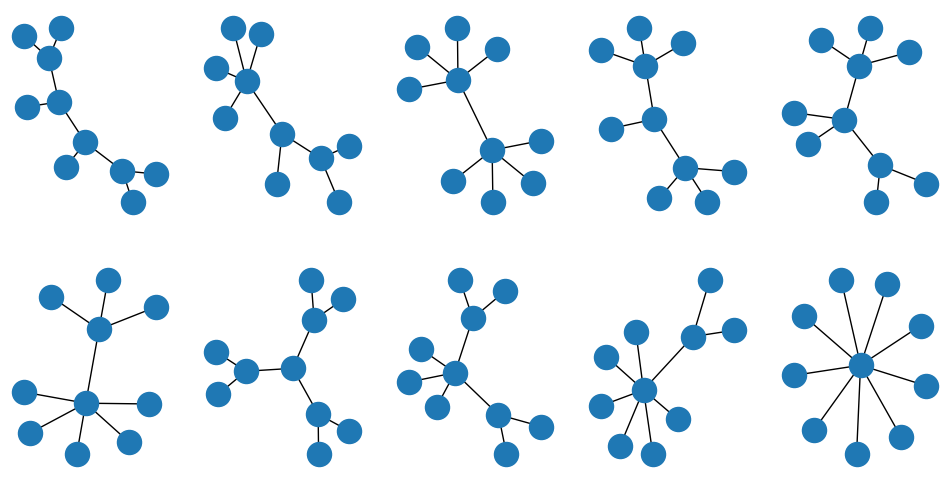

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))

for G, a in zip(nhi_trees, ax.ravel()):
    nx.draw(G, pos=nx.spring_layout(G, seed=1010, iterations=200), ax=a)